# **Importing Important Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib 
import os 
import PIL
from PIL import Image

# **Loading and Preprocessing Data**

In [2]:
data_dir = pathlib.Path("C:\\Users\\admin\\Downloads\\ML project final\\flower_images")
# print(len(list(data_dir.glob("*/*"))))


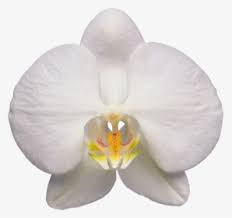

In [3]:
flowers = list(data_dir.glob('Orchid/*'))
PIL.Image.open(str(flowers[0]))

In [4]:
batch_size = 32
image_height = 224
image_width = 224
img_size = (224,224)   

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 4999 files belonging to 5 classes.
Using 4000 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 4999 files belonging to 5 classes.
Using 999 files for validation.


In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 16
Number of test batches: 16


In [9]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


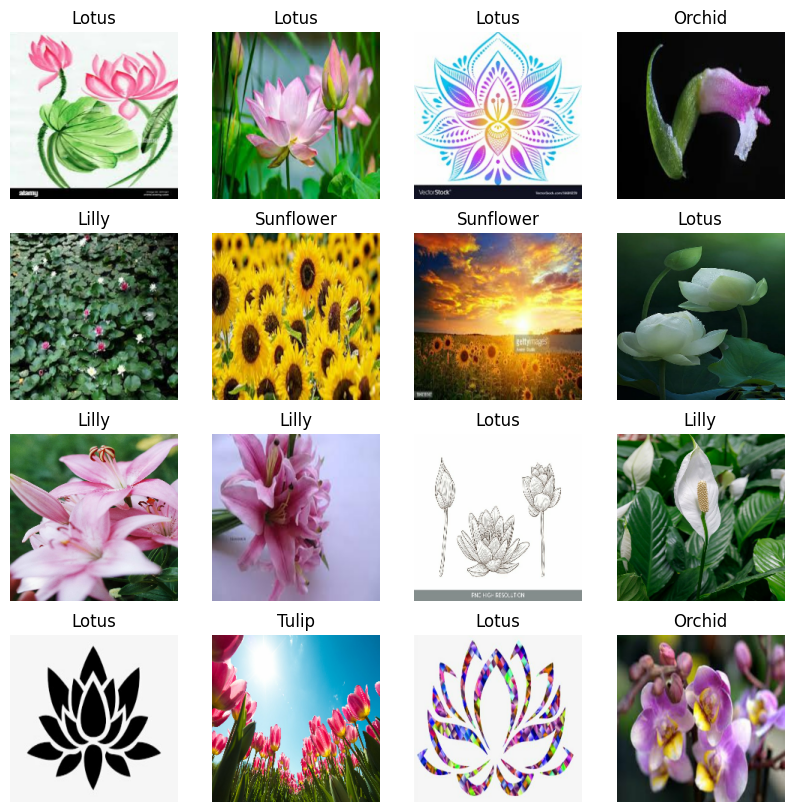

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# **Configure Dataset Performance**

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Load The Pre-trained Model - **RESNET50**

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [15]:
# Create a function to convert labels to one-hot encoding
num_classes = 5
def to_one_hot(x, y):
    num_classes = 5
    y_one_hot = tf.one_hot(y, num_classes)
    return x, y_one_hot

In [16]:
train_ds = train_ds.map(to_one_hot)
test_ds = test_ds.map(to_one_hot)
val_ds = val_ds.map(to_one_hot)

In [17]:
base_model = InceptionV3(input_shape=img_size + (3,),
                         weights='imagenet',
                         include_top=False)

In [18]:
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [19]:
for layer in base_model.layers[1:8]:
    layer.trainable=True

In [20]:
count=0
for layer in base_model.layers:
    if(layer.trainable):
        count+=1
        print(layer.get_config())
print(count)

{'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': False, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta

In [33]:
# Add new layers on top of the base model
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Reshape((16, 16, 1))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

In [34]:
# Define the model and compile it
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [36]:
log_dir = "logs/InceptionV3-ML-1.1"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

chpt = "Checkpoint/InceptionV3-ML-1.1"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = chpt+'/{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1)

In [44]:
test_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [37]:

epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=1,callbacks=[checkpoint_callback,tensorboard_callback])
# history = model.fit(train_generator,
#                     steps_per_epoch=train_generator.samples// batch_size,
#                     epochs=epochs,
#                     validation_data=valid_generator,
#                     validation_steps=valid_generator.samples // batch_size)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 1.5051 - accuracy: 0.3692
Epoch 1: saving model to Checkpoint/InceptionV3-ML-1.1\01.h5
125/125 [==============================] - 1239s 10s/step - loss: 1.5051 - accuracy: 0.3692 - val_loss: 0.9692 - val_accuracy: 0.6674
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6798
Epoch 2: saving model to Checkpoint/InceptionV3-ML-1.1\02.h5
125/125 [==============================] - 1167s 9s/step - loss: 0.8262 - accuracy: 0.6798 - val_loss: 0.8185 - val_accuracy: 0.6571
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7635
Epoch 3: saving model to Checkpoint/InceptionV3-ML-1.1\03.h5
125/125 [==============================] - 1190s 10s/step - loss: 0.6236 - accuracy: 0.7635 - val_loss: 0.5726 - val_accuracy: 0.7762
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.8110
Epoch 4: saving model to Checkpo

In [38]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


16/16 [==============================] - 41s 2s/step - loss: 0.1837 - accuracy: 0.9453
Test loss: 0.18366704881191254
Test accuracy: 0.9453125


In [ ]:
# model = tf.keras.models.load_model("Models/ResNet50-STBv1.0_10")


In [39]:
history.history

{'loss': [1.505102276802063,
  0.8262302279472351,
  0.6235595941543579,
  0.5407639145851135,
  0.4490180015563965,
  0.38986635208129883,
  0.3587455153465271,
  0.35360047221183777,
  0.294685959815979,
  0.3615787923336029,
  0.31810620427131653,
  0.26060524582862854,
  0.2134871929883957,
  0.2462584525346756,
  0.18256747722625732,
  0.1792149543762207,
  0.19135811924934387,
  0.16130731999874115,
  0.19950562715530396,
  0.1759089082479477,
  0.12734441459178925,
  0.13800878822803497,
  0.15206560492515564,
  0.1926194429397583,
  0.118598572909832,
  0.11570911109447479,
  0.11563284695148468,
  0.12466040998697281,
  0.13271024823188782,
  0.0919351652264595],
 'accuracy': [0.36924999952316284,
  0.6797500252723694,
  0.7634999752044678,
  0.8109999895095825,
  0.8392500281333923,
  0.8690000176429749,
  0.8762500286102295,
  0.8740000128746033,
  0.906000018119812,
  0.8769999742507935,
  0.8882499933242798,
  0.9112499952316284,
  0.9257500171661377,
  0.9139999747276306,

## Results

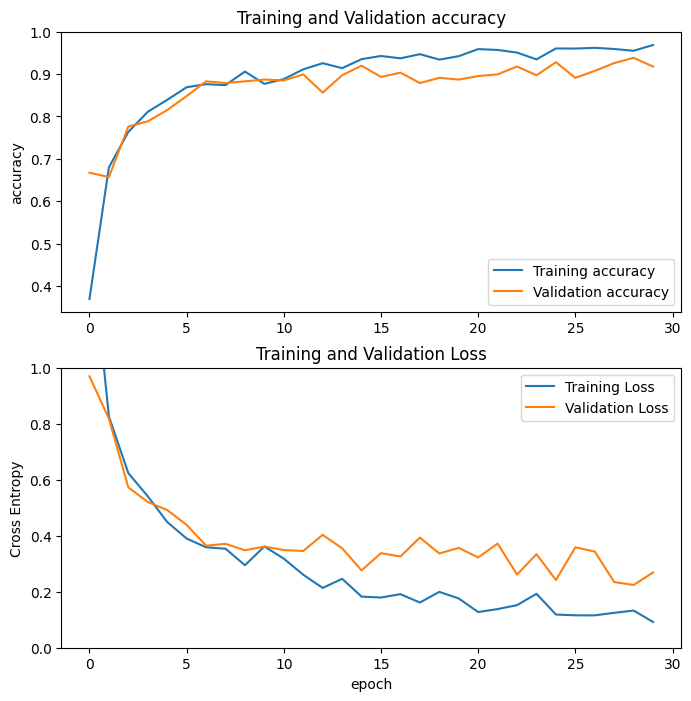

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# acc = history.history['precision_1']
# val_acc = history.history['val_precision_1']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [42]:
# model.save("Models/ResNet50-STBv1.0_8")
model.save("Models/InceptionV3-ML-1.1")

INFO:tensorflow:Assets written to: Models/InceptionV3-ML-1.0\assets


INFO:tensorflow:Assets written to: Models/InceptionV3-ML-1.0\assets
